# Sign language to speech program using Google's Mediapipe frame and tensorflow

In [ ]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## video extractor (recorder)

In [3]:
NO_VIDEOS = 60
NO_FRAMES = 30
IMAGE_SIZE = (384, 216)

ACTIONS = np.array(['happy', 'hello', 'please', 'thanks'])


In [ ]:
cap= cv2.VideoCapture(0)

width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer= cv2.VideoWriter('happy_nada.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

for video_num in range(NO_VIDEOS):
    for frame_num in range(NO_FRAMES):
        ret,frame= cap.read()
        writer.write(frame)
        if frame_num == 0:
            cv2.putText(frame, 'STARTING COLLECTION', (120,200),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
            cv2.putText(frame, 'Collecting frames Video Number {}'.format(video_num), (15,12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.imshow('OpenCV Feed', frame)
            # Show to screen
            cv2.waitKey(2000)
        else:
            cv2.putText(frame, 'Collecting frames Video Number {}'.format(video_num), (15,12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.imshow('OpenCV Feed', frame)
            # Show to screen


        if cv2.waitKey(40) & 0xFF == ord('q'):
            exit()


cap.release()
writer.release()
cv2.destroyAllWindows()


## video cutter
#### create a new video ever 30 frames in the selected video

In [ ]:
cap = cv2.VideoCapture("hello_Abbas.mp4")
ret, frame = cap.read()
h, w, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*"DIVX")

writers = [cv2.VideoWriter(f"data_set/hello/{fvid_no}.mp4", fourcc, 20, (w, h)) for fvid_no in range(0, NO_VIDEOS)]

f = 1
while ret:
    for writer in writers:
        for i in range(NO_FRAMES):
            if ret:
                print("frame" + str(f))
                f += 1
                writer.write(frame)
            ret, frame = cap.read()

for writer in writers:
    writer.release()

cap.release()

## get holistics from every video

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    # pose connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS)
    # left hand connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.left_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS)
    # right hand connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.right_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS,
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.left_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
                             mp.solutions.drawing_utils.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp.solutions.drawing_utils.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp.solutions.drawing_utils.draw_landmarks(image, results.right_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
                             mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )


In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [ ]:
cap = cv2.VideoCapture("./data_set/happy/0.mp4")
ret, frame = cap.read()
image = []
results = []
# Set mediapipe model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while ret:
        # Read feed

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        ret, frame = cap.read()
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    cap.release()
cv2.destroyAllWindows()

if results.left_hand_landmarks:
    print("left hand>>>>>")
    print(results.left_hand_landmarks.landmark)

if results.right_hand_landmarks:
    print("right hand>>>>>")
    print(results.right_hand_landmarks.landmark)

if results.pose_landmarks:
    print("pose >>>>")
    print(results.pose_landmarks.landmark)

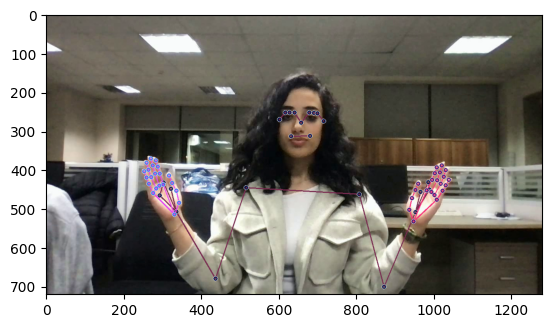

In [81]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [8]:
def generateVideoFeatureVector(video_dir, video_name):
    cap = cv2.VideoCapture(video_dir + "/" + video_name)
    ret, frame = cap.read()
    video_window = []

    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while ret:
            dim = IMAGE_SIZE
            # resize image
            frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
            # apply Mediapipe tracking
            image, results = mediapipe_detection(frame, holistic)
            # flattened feature vector for a frame
            frame_features = extract_keypoints(results)
            video_window.append(frame_features)
            ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    np.save(f'{video_dir}/{video_name}_features', video_window)

In [ ]:
frameFeatures = extract_keypoints(results)

print(frameFeatures)

In [ ]:

for action in ACTIONS:
    for i in range(0, NO_VIDEOS):
        generateVideoFeatureVector(f"data_set/{action}", f"{i}.mp4")


In [10]:
ff = np.load('./data_set/happy/0.mp4+_features.npy')

ff.shape

(30, 258)

In [9]:
label_map = {label:num for num, label in enumerate(ACTIONS)}

print(label_map)

{'happy': 0, 'hello': 1, 'please': 2, 'thanks': 3}


In [ ]:
labels = []
full_features = []
for action in ACTIONS:
    for i in range(0, NO_VIDEOS):
        vid_features = np.load(f'./data_set/{action}/{i}.mp4+_features.npy')
        full_features.append(vid_features)
        labels.append(label_map[action])


np.save('features', full_features)
np.save('labels', labels)

print(np.array(full_features).shape)
print(np.array(labels).shape)


(240, 30, 258)
(240,)


# TO GOOGLE COLAB ->>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
_features = np.load("features.npy")
_labels = np.load("labels.npy")

print(_features.shape)
print(_labels.shape)

(240, 30, 258)
(240,)


In [12]:
print(_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
print(_features)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# one-hot encoding
labels_categorical = to_categorical(_labels).astype(int)
labels_categorical

In [15]:
training_samples, test_samples, training_labels, test_labels = train_test_split(_features, labels_categorical, test_size=0.02, random_state=41)

In [16]:
test_samples.shape

(5, 30, 258)

In [17]:
training_samples.shape

(235, 30, 258)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# to make result  [0.2, 0.4, 0.1, 0.3]
model.add(Dense(ACTIONS.shape[0], activation='softmax'))

In [ ]:
del model

In [84]:
ACTIONS.shape

(4,)

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(training_samples, training_labels, epochs=120)

In [21]:
from sklearn.metrics import accuracy_score


In [ ]:
# print(test_samples.shape)
predicted_labels = model.predict(test_samples)

print(predicted_labels)
print(test_labels)
ytrue = np.argmax(test_labels, axis=1).tolist()
yhat = np.argmax(predicted_labels, axis=1).tolist()
print(yhat)
print(ytrue)
# accuracy_score(ytrue, yhat)


In [111]:
model.save('sign_language_weights_runningGood.h5')


In [22]:
model.load_weights('sign_language_weights_runningGood.h5')


### Google Text To Speech:

In [ ]:
!pip install gtts

In [25]:
from gtts import gTTS
import subprocess

In [24]:
USE_VOICE = True

In [42]:
processes = []

def text_to_speech(sentence):
    output = gTTS(sentence, lang='en', slow=False)
    output.save("output.mp3")
    process = subprocess.Popen("mpg123 output.mp3", shell=True)
    processes.append(process)

In [ ]:
text_to_speech("hello There")

## Testing 

In [43]:
colors = [(245,117,16), (117,245,16), (16,117,245), (230,20,230)]
def prob_viz(res, actions, input_frame):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.7

last_detect = ""
count_thresh = 3
curr_count = 0

cap = cv2.VideoCapture(0)

with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break
        image, results = mediapipe_detection(frame, holistic)

        # flattening( 258 )
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if ACTIONS[np.argmax(res)] != sentence[-1]:
                            sentence.append(ACTIONS[np.argmax(res)])
                    else:
                        sentence.append(ACTIONS[np.argmax(res)])
                        if USE_VOICE:
                            text_to_speech(sentence[-1])

            if len(sentence) > 1:
                if ACTIONS[np.argmax(res)] == sentence[-1]:
                    curr_count += 1
                    if(curr_count == count_thresh):
                        if USE_VOICE:
                            if sentence[-1] == "please":
                                text_to_speech(sentence[-1])
                            else:
                                text_to_speech(sentence[-1])

                            curr_count = -30
                else:
                    curr_count = 0

            if len(sentence) > 5:
                sentence = sentence[1:]
            image = prob_viz(res, ACTIONS, image)

        # draw_styled_landmarks(image, results)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

if USE_VOICE:
    output = [p.wait() for p in processes]